In [1]:

# We take in an (M, N, C) image array.  M and N are the dimensons of the
# image.  C denotes the channel. For each channel, we normalize the
# pixel distributions on [0,1]. We first need to break our (M, N, C) array
# into a C-length list of (M, N) arrays. List-comprehension allows us then to
# shift and scale each of the channels individually. We then stack the results
# back into a single array to return a normalzed (M, N, C) array.  This is used
# principally for visualization purposes, so that the results are compatible for
# rendering via matplotlib imshow. Use for other image-processing contexts is not
# anticipated.
def norm_image_channels(image_array):
    return np.dstack([((image_array[:,:,𝜈]-np.min(np.min(image_array[:,:,𝜈])))/\
                         (np.max(np.max(image_array[:,:,𝜈]))-np.min(np.min(image_array[:,:,𝜈]))))
                         if (np.max(np.max(image_array[:,:,𝜈]))-np.min(np.min(image_array[:,:,𝜈]))) != 0
                         else np.ones(image_array[:,:,𝜈].shape)
                         for 𝜈 in range(image_array.shape[-1])])


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-08-19 19:54:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com... 172.217.4.112, 2607:f8b0:4009:813::2010
Connecting to storage.googleapis.com|172.217.4.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  17.8MB/s    in 7.3s    

2019-08-19 19:54:38 (19.7 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [3]:

import os
import zipfile
from skimage.transform import resize
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.backend import resize_images
from tensorflow.keras.optimizers import RMSprop
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
from collections import Counter
import numpy as np
import random
import skimage
tf.__version__

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'2.0.0-alpha0'

The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

$$\mathcal{Bel}\big(\Omega \big) = \sum_{\omega \in \Omega} \mathcal{m}(\omega)$$

In [4]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [5]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

Now, let's see what the filenames look like in the `horses` and `humans` training directories:

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse28-2.png', 'horse46-2.png', 'horse22-1.png', 'horse40-3.png', 'horse29-7.png', 'horse31-4.png', 'horse15-9.png', 'horse29-1.png', 'horse33-9.png', 'horse12-4.png']
['human03-01.png', 'human17-08.png', 'human13-08.png', 'human16-01.png', 'human13-23.png', 'human03-00.png', 'human04-29.png', 'human05-20.png', 'human05-07.png', 'human02-17.png']


Let's find out the total number of horse and human images in the directories:

In [7]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

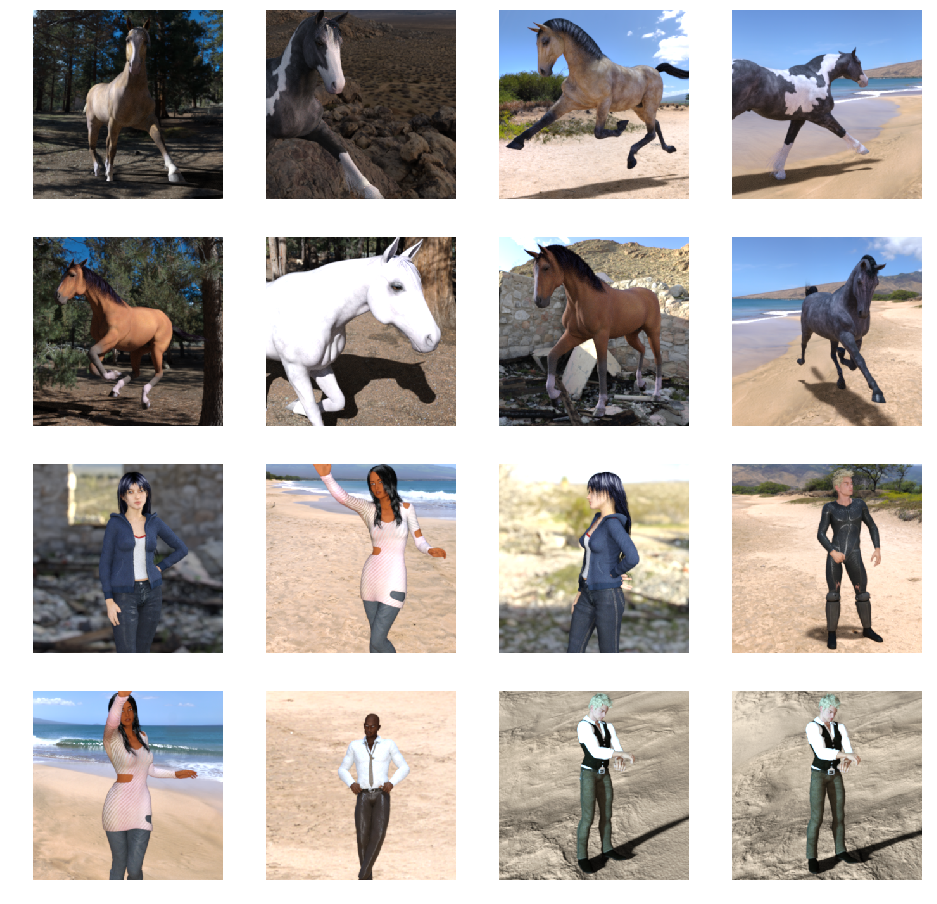

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in np.random.choice(a = train_horse_names,
                                              size = 8, 
                                              replace = False)]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in np.random.choice(a = train_human_names,
                                              size = 8,
                                              replace = False)]



for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


Explainable machine learning attracts considerable interest by the research community. It frequently occurs in practice that goodness of fit alone is insufficient. We seek to understand why a model behaves a certain way. The opacity of highly-popular artificial neural network methods renders this difficult.  

Different approaches to model-explanation occur. C. Rudin compared results from opaque machine learning with those from more-transparent, classical statistical methods. Such comparisons lead to insight if results coincide closely. 

Dreyfus similarly applies the machinery of classical statistics to opaque machine learning. He uses both Fisher's "partial F-test" method, and a "probe-feature" method. Both attempt to rank model inputs according to their marginal contributions to the outputs.

Application of methods from system identification might also be considered. A machine-learning algorithm — an artificial-neural network, for example — might be thought of as a system that transforms inputs into outputs. The dimensionality of the feature space is, of course, vast in most cases. Moreover, within the network graph itself, quantity of weights $\{w_{i,j}\}$ themselves can be vast. 

If we can reduce the dimensionality if the input space, then the relationship between outputs and points on the loci of input states might be identified. Consider, for example, a classification problem. 



#### Discrete Wavelet Transform (DWT) decomposition of images

We seek to compare the filter-and-pooling operation of convolutional neural networks with an alternative multi-scale decomposition, the discrete wavelet transform (DWT). By selecting Daubechies wavelets, our DWT operations become orthonormal-transform decompositions with perfect reconstructability. 





In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os 


# Pick an arbitrary image. Resize it and convert its color to three color channels, 
# red, green, blue.  For reconstructability — our goal — our output-shape dimensions
# must be an integer-factor length of the coefficient.
horse50_1 = color.rgba2rgb(resize(image = mpimg.imread(os.path.join(train_horse_dir, 
                                                                      'horse50-1.png')),
                                  output_shape = (256,256,4),
                                  order = 3))
#
# We now seek to visualize the full DWT composition. Use Daubechies wavelets.
# Our pywavelets function returns [cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)],
# where n denotes the number of decomposed levels; and cAν, cHν, cVν, cDν
# the approximate, horizontal-detail, vertical-detail, and "diagonal"-detail
# coefficient arrays at the νᵗʰ level.
horse50_1_dwt  = dict(enumerate(pywt.wavedec2(data = horse50_1, 
                                                 wavelet = 'db2',
                                                 axes = (0,1))))
#
# We want our visualization to include the approximate and detail components
# for each decompositional layer. We need therefore to restructure things a little bit.
# We want to have for each layer ν, all four coeficient arrays — cAν, cHν, cVν, and cDν.
# Organizing this into a dictionary might moreover be convenient. 
#
# Furthermore, we only have cAν for the coarsest level.  We have to fill in the remaining cAν's.
# We do this by iteratively calling the inverse discrete-wavelet  transform idwt2
# in order to build in all of the cAν's for all of the levels.  For the highest level,
# write or ouriginal image as cAν and identically-shaped arrays of zeros as the detail 
# components.
multires_struc = {0 : {'cAν' : horse50_1_dwt.get(0),
                       'cHν' : horse50_1_dwt.get(1)[0],
                       'cVν' : horse50_1_dwt.get(1)[1],
                       'cDν' : horse50_1_dwt.get(1)[2]} }
for μ in list(horse50_1_dwt.keys())[2:]:
    multires_struc.update({μ-1 : {'cAν' : pywt.idwt2(coeffs = (multires_struc.get(μ-2).get('cAν'),
                                                                 (multires_struc.get(μ-2).get('cHν'),
                                                                  multires_struc.get(μ-2).get('cVν'),
                                                                  multires_struc.get(μ-2).get('cDν'))),
                                                       wavelet = 'db2',
                                                       axes = (0,1)),
                                   'cHν' : horse50_1_dwt.get(μ)[0],
                                   'cVν' : horse50_1_dwt.get(μ)[1],
                                   'cDν' : horse50_1_dwt.get(μ)[2]}})
multires_struc.update({list(horse50_1_dwt.keys())[-1] : 
                        {'cAν' : horse50_1,
                         'cHν' : np.zeros(shape = horse50_1.shape),
                         'cVν' : np.zeros(shape = horse50_1.shape),
                         'cDν' : np.zeros(shape = horse50_1.shape)}})

In [16]:
multires_struc.get(0).keys()

dict_keys(['cVν', 'cHν', 'cAν', 'cDν'])

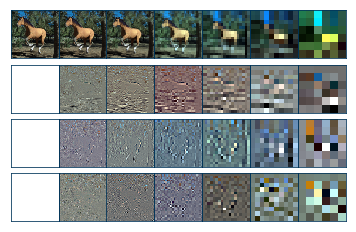

'/data/home/neil_hamlett/notebooks/dwt_horse50_1.png'

In [19]:
# VISUALIZE THE FULL DWT MULTI-RESOLUTION STRUCTURE. Conduct an array
# of images showing the sets of coefficients at each scale. 
dwt_components = dict(enumerate(['cAν', 'cHν', 'cVν', 'cDν']))
img_grid=gridspec.GridSpec(ncols = len(multires_struc), 
                           nrows = len(dwt_components),
                           wspace=0,
                           hspace=0)
for μ in multires_struc.keys():
    for ν in dwt_components.keys():
        ax=plt.subplot(img_grid[ν:(ν+1), 
                                (len(multires_struc)-μ-1):(len(multires_struc)-μ)])
        ax.imshow(norm_image_channels(multires_struc.get(μ).get(dwt_components.get(ν))))
        plt.xticks([])
        plt.yticks([])
        ax.spines['top'].set_color('#003459')
        ax.spines['bottom'].set_color('#003459')
        ax.spines['left'].set_color('#003459')
        ax.spines['right'].set_color('#003459')
        ax.set_aspect('equal')
plt.savefig('dwt_horse50_1.png',
             dpi = 1200,
             tranparent = True,
             bbox_inches = 'tight')
plt.show()
os.path.abspath('dwt_horse50_1.png')






In [93]:
list(img_grid.get_height_ratios)

TypeError: 'method' object is not iterable

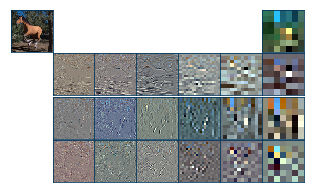

'/data/home/neil_hamlett/notebooks/dwt_horse50_1.png'

In [12]:
#
# VISUALIZE THE FULL DWT.  We now build an array of images of the full DWT. We 
# want to plot the progresively-coarse detail. The wavedec2 function returns
# DWT coefficients in progressively-finer detail. We therefore reverse the 
# result from wavedec2.  
#
# If our wavedec2 contains 𝘕 components, we want an image array of  𝘕+1
# rows, so that we can show the original image in the first array. This
# can be thought of as CA0.
horse50_1 = color.rgba2rgb(resize(mpimg.imread(os.path.join(train_horse_dir, 
                                                            'horse50-1.png')),
                                    output_shape = (300,300,4)))

multi_lvl_DWT = list(reversed(pywt.wavedec2(data = horse50_1,
                                            axes = (0,1),
                                            wavelet = 'db2')))

img_grid=gridspec.GridSpec(ncols = len(multi_lvl_DWT)+1, 
                           nrows = 5,
                           wspace=0,
                           hspace=0)
ax=plt.subplot(img_grid[0:1,0:1])
ax.imshow(horse50_1)
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_color('#003459')
ax.spines['bottom'].set_color('#003459')
ax.spines['left'].set_color('#003459')
ax.spines['right'].set_color('#003459')
ax.set_aspect('equal')
for 𝜇 in range(len(multi_lvl_DWT)-1):
#     ax=plt.subplot(img_grid[0:1, (𝜇+1):(𝜇+2)])    # 
#     plt.xticks([])
#     plt.yticks([])
#     ax.text(x = 1/8,
#             y = 1/2,
#             s = str((0, 𝜇+1)))
#     ax.spines['top'].set_color('#003459')
#     ax.spines['bottom'].set_color('#003459')
#     ax.spines['left'].set_color('#003459')
#     ax.spines['right'].set_color('#003459')
#     ax.set_aspect('equal')
    for 𝜈 in range(3):
        ax=plt.subplot(img_grid[𝜈+1:(𝜈+2), (𝜇+1):(𝜇+2)])

        ax.imshow(norm_image_channels(multi_lvl_DWT[𝜇][𝜈]))
        plt.xticks([])
        plt.yticks([])
#         ax.text(x = 1/8,
#                 y = 1/2,
#                 s = str((𝜈+1, 𝜇+1)))
        ax.spines['top'].set_color('#003459')
        ax.spines['bottom'].set_color('#003459')
        ax.spines['left'].set_color('#003459')
        ax.spines['right'].set_color('#003459')
        ax.set_aspect('equal')
ax=plt.subplot(img_grid[0:1, (len(multi_lvl_DWT)-1):(len(multi_lvl_DWT))])
ax.imshow(norm_image_channels(multi_lvl_DWT[-1]))
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_color('#003459')
ax.spines['bottom'].set_color('#003459')
ax.spines['left'].set_color('#003459')
ax.spines['right'].set_color('#003459')
ax.set_aspect('equal')
plt.savefig('dwt_horse50_1.png',
             dpi = 1200,
             tranparent = True,
             bbox_inches = 'tight')
plt.show()
os.path.abspath('dwt_horse50_1.png')

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import itertools as it
horse50_1 = color.rgba2rgb(resize(mpimg.imread(os.path.join(train_horse_dir, 
                                                            'horse50-1.png')),
                                    output_shape = (75,75,4)))
multi_lvl_DWT = dict(enumerate(pywt.wavedec2(data = horse50_1,
                                            axes = (0,1),
                                            wavelet = 'db2')))

In [14]:
{key : len(val) 
    for (key, val) in list(multi_lvl_DWT.items())}

{0: 7, 1: 3, 2: 3, 3: 3, 4: 3}

In [15]:
μ = list(multi_lvl_DWT.keys())[1]
pywt.waverec2(coefs = ())


In [25]:
multi_lvl_DWT[1][0].shape

(7, 7, 3)

In [15]:
!jupyter --paths

config:
    /data/home/neil_hamlett/.jupyter
    /data/anaconda/envs/py35/etc/jupyter
    /usr/local/etc/jupyter
    /etc/jupyter
data:
    /data/home/neil_hamlett/.local/share/jupyter
    /data/anaconda/envs/py35/share/jupyter
    /usr/local/share/jupyter
    /usr/share/jupyter
runtime:
    /data/home/neil_hamlett/.local/share/jupyter/runtime


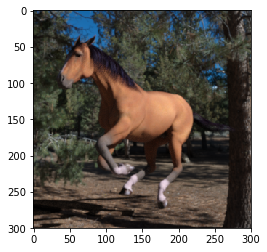

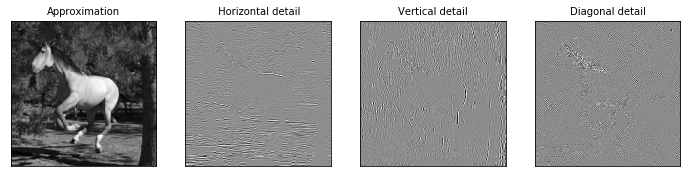

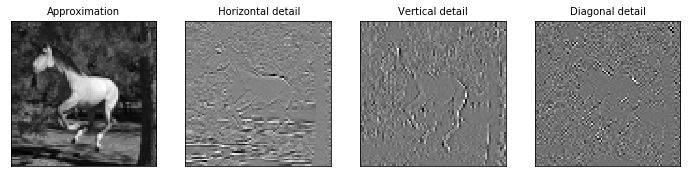

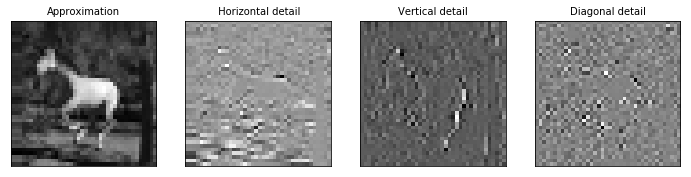

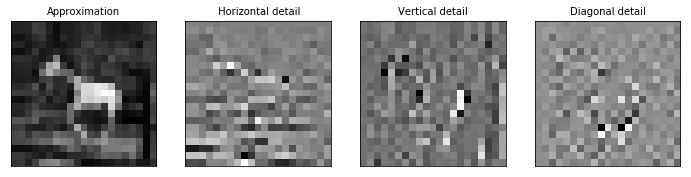

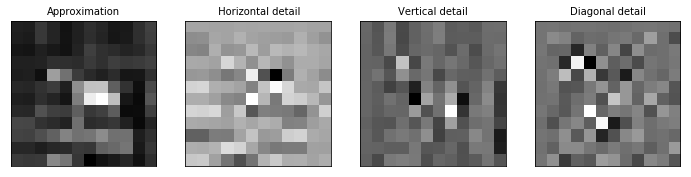

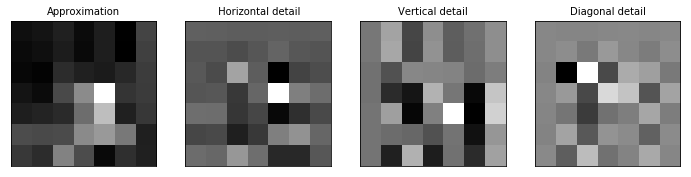

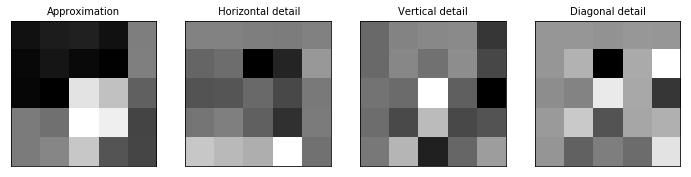

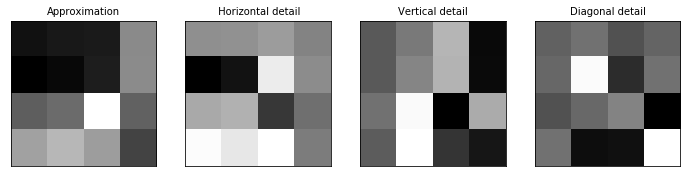

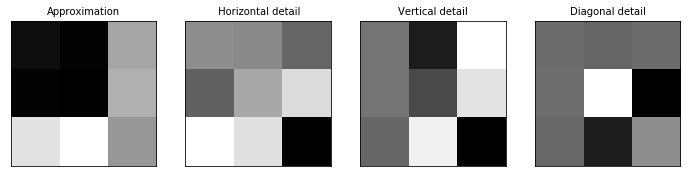

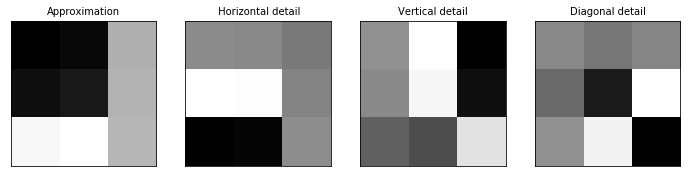

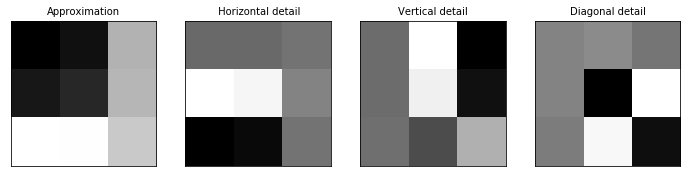

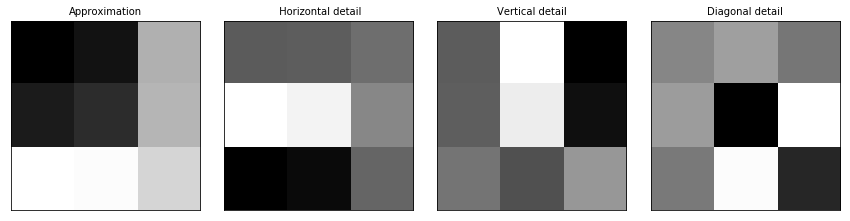

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()
img = mpimg.imread(os.path.join(train_horse_dir, 
                                'horse50-1.png'))
plt.imshow(img)
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(img[:,:,0], 'db4')
LL, (LH, HL, HH) = coeffs2
coeffsl2 = pywt.dwt2(LL,'db2')
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
LL, (LH, HL, HH) = coeffsl2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl3 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl3
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl4 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl4
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl5 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl5
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl6 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl6
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl7 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl7
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl8 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl8
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl9 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl9
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl10 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl10
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl11 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl11
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
coeffsl12 = pywt.dwt2(LL,'db2')
LL, (LH, HL, HH) = coeffsl12
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.tight_layout()
plt.show()


In [14]:
full_dwt = pywt.wavedec2(data = img[:,:,:-1], 
                          wavelet = 'db4', 
                          mode='symmetric', 
                          axes = (0,1),
                          level=None)


list

In [17]:
full_dwt[-1:][0][0].shape

(153, 153, 3)

In [15]:
img_grid = gridspec.GridSpec(nrows = len(full_dwt),
                             ncols = 3,
                             wspace = 0,
                             hspace = 0)
ax = plt.subplot(0,0)
plt.imshow(full_dwt[0])


ValueError: Illegal argument(s) to subplot: (0, 0)

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


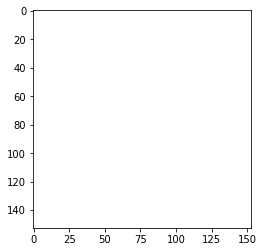

In [88]:
pywt.dwt2(data = img[:,:,:], 
          wavelet = 'db4',
         axes = (0,1))[1][0]

In [97]:
from skimage import transform

ImportError: cannot import name '_validate_lengths'

In [95]:
LL, (LH, HL, HH) = pywt.dwt2(data = img[:,:,:], 
                              wavelet = 'db4',
                             axes = (0,1))

In [100]:
import skimage
skimage.__version__

'0.13.1'

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [11]:
import tensorflow as tf
tf.__version__

'1.13.1'

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [43]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary() method call prints a summary of the NN 

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)        36928     
__________

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
9/9 [==============================] - 118s 13s/step - loss: 0.9851 - acc: 0.5326
Epoch 2/15
9/9 [==============================] - 114s 13s/step - loss: 1.2466 - acc: 0.8130
Epoch 3/15
9/9 [==============================] - 114s 13s/step - loss: 0.4818 - acc: 0.7722
Epoch 4/15
9/9 [==============================] - 114s 13s/step - loss: 0.5255 - acc: 0.8510
Epoch 5/15
9/9 [==============================] - 114s 13s/step - loss: 0.2591 - acc: 0.9036
Epoch 6/15
9/9 [==============================] - 114s 13s/step - loss: 0.2685 - acc: 0.8987
Epoch 7/15
9/9 [==============================] - 114s 13s/step - loss: 0.1099 - acc: 0.9620
Epoch 8/15
9/9 [==============================] - 114s 13s/step - loss: 0.0433 - acc: 0.9834
Epoch 9/15
9/9 [==============================] - 114s 13s/step - loss: 0.2407 - acc: 0.9085
Epoch 10/15
9/9 [==============================] - 113s 13s/step - loss: 0.0520 - acc: 0.9786
Epoch 11/15
9/9 [====

###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [17]:
#import numpy as np
#from google.colab import files
#from keras.preprocessing import image

#uploaded = files.upload()

#for fn in uploaded.keys():
 
  # predicting images
#  path = '/content/' + fn
#  img = image.load_img(path, target_size=(300, 300))
#  x = image.img_to_array(img)
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(fn + " is a human")
#  else:
#    print(fn + " is a horse")
 

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


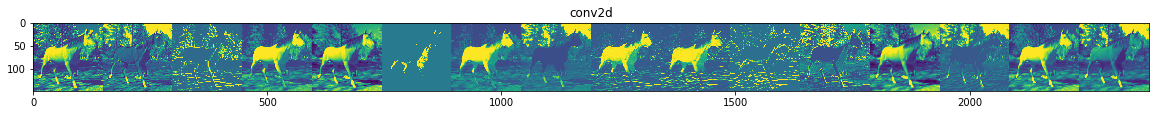

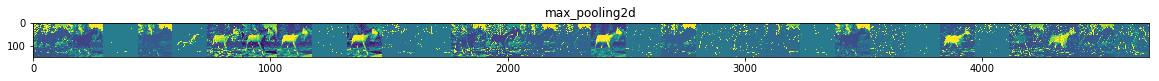

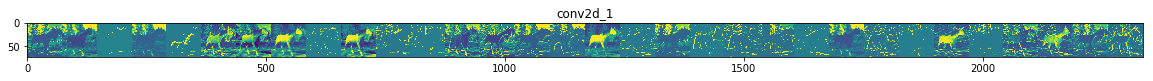

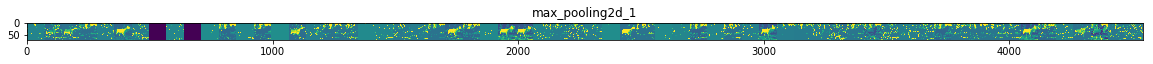

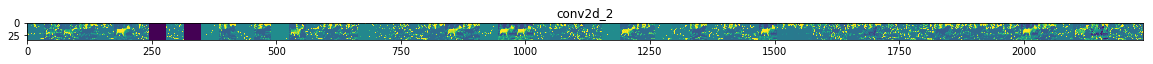

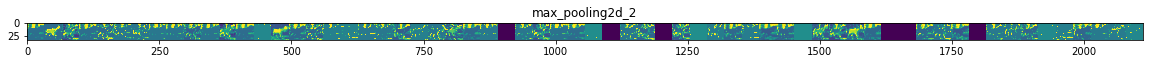

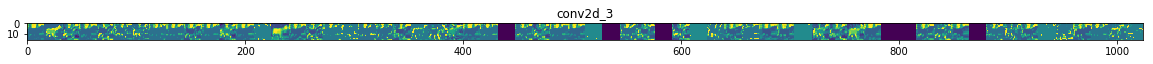

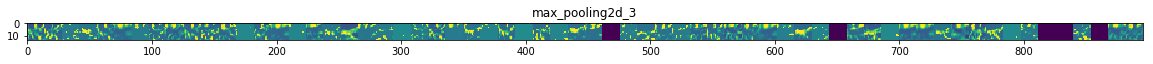

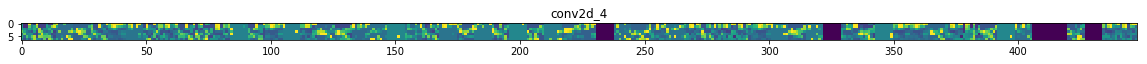

In [18]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)